# GDPR Analysis Main Notebook 

**Goal** 
The goal of this notebook is to demonstrate usage of this codebase as well as ultimately assembling the main "dataframe" of [this](https://arxiv.org/pdf/1809.08396.pdf) study. The code corresponding to each section is provided as separate blocks in this notebook. 

In [1]:
import pandas as pd
from pathlib import Path
from scipy import stats 
import json
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

A **note** about the code: The data for this study is partitioned into two sets, _EU_ and _Global_ based on the geographic location of the domain. Most of the analysis is done by sequentially applying a process to each set before moving on, and the code will reflect as much. 

Dataframes containing the mapping from PID to the url, along with the pre-GDPR timestamps and post-GDPR timestamps

In [172]:
eu_df = pd.read_csv('./eu_dataframe_with_url.csv')
g_df = pd.read_csv('./global_dataframe_with_url.csv')

In [173]:
eu_df.head()

,pid,post_ts,pre_ts,policy_url
0,3405,201811,201710,https://www.narcity.com/privacy-policy
1,32575,201905,201611,https://www.enjin.com/privacy
2,7058,201905,201806,http://www.hearst.com/newsroom/us-magazines-pr...
3,18261,201905,201804,https://medium.com/policy/medium-privacy-polic...
4,29709,201808,201801,https://dotapicker.com/privacy


`eu_dict` and `g_dict` are dictionaries to keep track of html directories, text data and polisis outputs

In [36]:
eu_dict = {}
for i in eu_df.itertuples():
    eu_dict[i.pid] = {'pid': i.pid, 'pre_ts':i.pre_ts, 'post_ts':i.post_ts}
    continue

In [4]:
g_dict = {}
for i in g_df.itertuples():
    g_dict[i.pid] = {'pid': i.pid, 'pre_ts':i.pre_ts, 'post_ts':i.post_ts}
    continue

The analysis below assumes that you have downloaded the dataset from [here](https://uwmadison.box.com/s/v6girx83x0krai1k45vnn41w21brn4hi) and extracted in the root folder. See README for more information

## Raw HTML

**EU** 

In [5]:
eu_html_dir = Path('./GDPR_Data/raw_html/EU/')
for path in eu_html_dir.iterdir(): 
    if not path.is_dir(): continue 
    try: 
        pid = int(str(path).split('/')[-1])
        if eu_dict.get(pid) is not None: eu_dict[pid]['raw_html_dir'] = str(path)
    except: 
        continue
    continue 

**Global**

In [6]:
g_html_dir = Path('./GDPR_Data/raw_html/Global/')
for path in g_html_dir.iterdir(): 
    if not path.is_dir(): continue 
    try: 
        pid = int(str(path).split('/')[-1])
        if g_dict.get(pid) is not None: g_dict[pid]['raw_html_dir'] = str(path)
    except: 
        continue
    continue 

## Text Data

**EU**

In [7]:
eu_text_dir = Path('./GDPR_Data/text_data/EU/')
for path in eu_text_dir.iterdir(): 
    if not path.is_dir(): continue 
    try: 
        pid = int(str(path).split('/')[-1])
        if eu_dict.get(pid) is not None: eu_dict[pid]['text_dir'] = str(path)
    except: 
        continue
    continue 

**Global**

In [8]:
g_text_dir = Path('./GDPR_Data/text_data/Global/')
for path in g_text_dir.iterdir(): 
    if not path.is_dir(): continue 
    try: 
        pid = int(str(path).split('/')[-1])
        if g_dict.get(pid) is not None: g_dict[pid]['text_dir'] = str(path)
    except: 
        continue
    continue 

## Polisis Outputs

**EU**

In [9]:
eu_polisis_pre_dir = Path('./GDPR_Data/polisis_outputs/EU/pre_data/')
for f in eu_polisis_pre_dir.iterdir(): 
    if not str(f).endswith('.json'): continue
    try: 
        pid = int(str(f).split('/')[-1].replace('.json', ''))
        if eu_dict.get(pid) is not None: eu_dict[pid]['pre_polisis_output'] = str(f)
    except:
        continue
    continue

In [10]:
eu_polisis_post_dir = Path('./GDPR_Data/polisis_outputs/EU/post_data/')
for f in eu_polisis_post_dir.iterdir(): 
    if not str(f).endswith('.json'): continue
    try: 
        pid = int(str(f).split('/')[-1].replace('.json', ''))
        if eu_dict.get(pid) is not None: eu_dict[pid]['post_polisis_output'] = str(f)
    except:
        continue
    continue

**Global**

In [11]:
g_polisis_pre_dir = Path('./GDPR_Data/polisis_outputs/Global/pre_data/')
for f in g_polisis_pre_dir.iterdir(): 
    if not str(f).endswith('.json'): continue
    try: 
        pid = int(str(f).split('/')[-1].replace('.json', ''))
        if g_dict.get(pid) is not None: g_dict[pid]['pre_polisis_output'] = str(f)
    except:
        continue
    continue

In [12]:
g_polisis_post_dir = Path('./GDPR_Data/polisis_outputs/Global/post_data/')
for f in g_polisis_post_dir.iterdir(): 
    if not str(f).endswith('.json'): continue
    try: 
        pid = int(str(f).split('/')[-1].replace('.json', ''))
        if g_dict.get(pid) is not None: g_dict[pid]['post_polisis_output'] = str(f)
    except:
        continue
    continue

## Text Feature Analysis (Section 5 in Paper)

This section demonstrates how the text of the policies evolved over time. These features allow us to get
a high-level understanding of how the policy’s structure
evolved before we go deeper into semantic features in the
later sections.

**Methods**

In [13]:
from utils.passive_voice_index import PassiveVoice
import textstat

In order to run the below command from the notebook

```python
pv = PassiveVoice()
```

please download the appropriate model using the command

``` bash
python -m spacy download en_core_web_lg
```

before running the code in the virtual environment. If you are not running in virtual environment, then you might need to use 

``` bash
sudo python -m spacy download en_core_web_lg
```

In [14]:
pv = PassiveVoice()

In [15]:
def calculate_readability_scores(path, pv):
    txt = ''
    with open(path) as fi: 
        txt = fi.read()
    local = {}
    try:
        local['syllables'] = textstat.syllable_count(txt)
    except:
        local['syllables'] = 0
    try:
        local['words'] = textstat.lexicon_count(txt, True)
    except:
        local['words'] = 0
    try:
        local['sentences'] = textstat.sentence_count(txt)
    except:
        local['sentences'] = 0    
    if local.get('words') > 0: 
        local['syllables_per_word'] = local.get('syllables') / local.get('words')
    else: 
        local['syllables_per_word'] = 0
    if local.get('sentences') > 0: 
        local['words_per_sentence'] = local.get('words') / local.get('sentences')
    else: 
        local['words_per_sentence'] = 0
    try: 
        local['passive_voice'] = pv.index(txt)[0]
    except: 
        local['passive_voice'] = 'NA'
    return local

In [ ]:
## Calculating readability scores for EU dataset for pre and post GDPR

eu_pre_scores_dict = {}
eu_post_scores_dict = {}
for obj in eu_dict.values():
    try: 
        pre_txt_fname = obj.get('text_dir') + '/%s.txt' % str(obj.get('pre_ts'))
        eu_pre_scores_dict[obj.get('pid')] = calculate_readability_scores(pre_txt_fname, pv)
        post_txt_fname = obj.get('text_dir') + '/%s.txt' % str(obj.get('post_ts'))
        eu_post_scores_dict[obj.get('pid')] = calculate_readability_scores(post_txt_fname, pv)
    except Exception as e: 
        continue
    continue

Number of Sentences =  25
Number of Passive Sentences =  5
Number of Sentences =  42
Number of Passive Sentences =  5
Number of Sentences =  85
Number of Passive Sentences =  10
Number of Sentences =  89
Number of Passive Sentences =  8
Number of Sentences =  329
Number of Passive Sentences =  13
Number of Sentences =  327
Number of Passive Sentences =  13
Number of Sentences =  43
Number of Passive Sentences =  2
Number of Sentences =  127
Number of Passive Sentences =  9
Number of Sentences =  72
Number of Passive Sentences =  2
Number of Sentences =  74
Number of Passive Sentences =  2
Number of Sentences =  161
Number of Passive Sentences =  18
Number of Sentences =  161
Number of Passive Sentences =  18
Number of Sentences =  68
Number of Passive Sentences =  6
Number of Sentences =  30
Number of Passive Sentences =  4
Number of Sentences =  43
Number of Passive Sentences =  2
Number of Sentences =  43
Number of Passive Sentences =  2
Number of Sentences =  61
Number of Passive Se

Number of Sentences =  77
Number of Passive Sentences =  12
Number of Sentences =  222
Number of Passive Sentences =  9
Number of Sentences =  208
Number of Passive Sentences =  11
Number of Sentences =  84
Number of Passive Sentences =  2
Number of Sentences =  249
Number of Passive Sentences =  31
Number of Sentences =  48
Number of Passive Sentences =  3
Number of Sentences =  106
Number of Passive Sentences =  17
Number of Sentences =  155
Number of Passive Sentences =  28
Number of Sentences =  167
Number of Passive Sentences =  30
Number of Sentences =  1138
Number of Passive Sentences =  12
Number of Sentences =  70
Number of Passive Sentences =  5
Number of Sentences =  37
Number of Passive Sentences =  2
Number of Sentences =  96
Number of Passive Sentences =  12
Number of Sentences =  43
Number of Passive Sentences =  2
Number of Sentences =  46
Number of Passive Sentences =  2
Number of Sentences =  100
Number of Passive Sentences =  15
Number of Sentences =  399
Number of P

Number of Sentences =  83
Number of Passive Sentences =  7
Number of Sentences =  208
Number of Passive Sentences =  30
Number of Sentences =  208
Number of Passive Sentences =  30
Number of Sentences =  80
Number of Passive Sentences =  9
Number of Sentences =  102
Number of Passive Sentences =  13
Number of Sentences =  9
Number of Passive Sentences =  3
Number of Sentences =  22
Number of Passive Sentences =  3
Number of Sentences =  56
Number of Passive Sentences =  7
Number of Sentences =  161
Number of Passive Sentences =  23
Number of Sentences =  34
Number of Passive Sentences =  1
Number of Sentences =  33
Number of Passive Sentences =  1
Number of Sentences =  223
Number of Passive Sentences =  16
Number of Sentences =  108
Number of Passive Sentences =  7
Number of Sentences =  221
Number of Passive Sentences =  12
Number of Sentences =  221
Number of Passive Sentences =  12
Number of Sentences =  192
Number of Passive Sentences =  45
Number of Sentences =  865
Number of Pas

Number of Sentences =  272
Number of Passive Sentences =  25
Number of Sentences =  279
Number of Passive Sentences =  25
Number of Sentences =  57
Number of Passive Sentences =  4
Number of Sentences =  81
Number of Passive Sentences =  13
Number of Sentences =  44
Number of Passive Sentences =  4
Number of Sentences =  24
Number of Passive Sentences =  0
Number of Sentences =  57
Number of Passive Sentences =  5
Number of Sentences =  57
Number of Passive Sentences =  5
Number of Sentences =  65
Number of Passive Sentences =  8
Number of Sentences =  70
Number of Passive Sentences =  9
Number of Sentences =  43
Number of Passive Sentences =  5
Number of Sentences =  337
Number of Passive Sentences =  2
Number of Sentences =  49
Number of Passive Sentences =  4
Number of Sentences =  206
Number of Passive Sentences =  27
Number of Sentences =  14
Number of Passive Sentences =  1
Number of Sentences =  142
Number of Passive Sentences =  10
Number of Sentences =  58
Number of Passive Se

Number of Sentences =  29
Number of Passive Sentences =  3
Number of Sentences =  110
Number of Passive Sentences =  18
Number of Sentences =  110
Number of Passive Sentences =  18
Number of Sentences =  215
Number of Passive Sentences =  15
Number of Sentences =  440
Number of Passive Sentences =  42
Number of Sentences =  33
Number of Passive Sentences =  1
Number of Sentences =  104
Number of Passive Sentences =  9
Number of Sentences =  25
Number of Passive Sentences =  5
Number of Sentences =  25
Number of Passive Sentences =  5
Number of Sentences =  101
Number of Passive Sentences =  9
Number of Sentences =  23
Number of Passive Sentences =  3
Number of Sentences =  10
Number of Passive Sentences =  2
Number of Sentences =  18
Number of Passive Sentences =  0
Number of Sentences =  113
Number of Passive Sentences =  9
Number of Sentences =  115
Number of Passive Sentences =  9
Number of Sentences =  206
Number of Passive Sentences =  39
Number of Sentences =  672
Number of Passi

Number of Sentences =  165
Number of Passive Sentences =  7
Number of Sentences =  149
Number of Passive Sentences =  10
Number of Sentences =  60
Number of Passive Sentences =  5
Number of Sentences =  70
Number of Passive Sentences =  6
Number of Sentences =  8
Number of Passive Sentences =  2
Number of Sentences =  22
Number of Passive Sentences =  2
Number of Sentences =  94
Number of Passive Sentences =  13
Number of Sentences =  22
Number of Passive Sentences =  6
Number of Sentences =  82
Number of Passive Sentences =  10
Number of Sentences =  94
Number of Passive Sentences =  10
Number of Sentences =  62
Number of Passive Sentences =  1
Number of Sentences =  57
Number of Passive Sentences =  1
Number of Sentences =  243
Number of Passive Sentences =  20
Number of Sentences =  248
Number of Passive Sentences =  20
Number of Sentences =  73
Number of Passive Sentences =  4
Number of Sentences =  107
Number of Passive Sentences =  17
Number of Sentences =  57
Number of Passive S

In [31]:
## Calculating readability scores for EU dataset for pre and post GDPR
g_pre_scores_dict = {}
g_post_scores_dict = {}
for obj in g_dict.values():
    try: 
        pre_txt_fname = obj.get('text_dir') + '/%s.txt' % str(obj.get('pre_ts'))
        g_pre_scores_dict[obj.get('pid')] = calculate_readability_scores(pre_txt_fname, pv)
        post_txt_fname = obj.get('text_dir') + '/%s.txt' % str(obj.get('post_ts'))
        g_post_scores_dict[obj.get('pid')] = calculate_readability_scores(post_txt_fname, pv)
    except Exception as e: 
        print(e)
        continue
    continue

Number of Sentences =  25
Number of Passive Sentences =  1
Number of Sentences =  36
Number of Passive Sentences =  1
Number of Sentences =  63
Number of Passive Sentences =  11
Number of Sentences =  137
Number of Passive Sentences =  22
Number of Sentences =  37
Number of Passive Sentences =  2
Number of Sentences =  33
Number of Passive Sentences =  2
Number of Sentences =  112
Number of Passive Sentences =  0
Number of Sentences =  105
Number of Passive Sentences =  0
Number of Sentences =  173
Number of Passive Sentences =  10
Number of Sentences =  158
Number of Passive Sentences =  10
Number of Sentences =  27
Number of Passive Sentences =  3
Number of Sentences =  38
Number of Passive Sentences =  3
Number of Sentences =  44
Number of Passive Sentences =  2
Number of Sentences =  44
Number of Passive Sentences =  2
Number of Sentences =  150
Number of Passive Sentences =  13
Number of Sentences =  154
Number of Passive Sentences =  14
Number of Sentences =  110
Number of Passiv

In [32]:
## Merging the dictionaries and converting them into a dataframe
eu_score_datarows = []
for pid in eu_post_scores_dict:
    pre_data = eu_pre_scores_dict.get(pid)
    post_data = eu_post_scores_dict.get(pid)
    local_object = {'pid':pid}
    for i in eu_pre_scores_dict[pid].items(): local_object['pre_' + i[0]] = i[1]
    for i in eu_post_scores_dict[pid].items(): local_object['post_' + i[0]] = i[1]
    eu_score_datarows.append(local_object)
    continue

In [33]:
g_score_datarows = []
for pid in g_post_scores_dict:
    pre_data = g_pre_scores_dict.get(pid)
    post_data = g_post_scores_dict.get(pid)
    local_object = {'pid':pid}
    for i in g_pre_scores_dict[pid].items(): local_object['pre_' + i[0]] = i[1]
    for i in g_post_scores_dict[pid].items(): local_object['post_' + i[0]] = i[1]
    g_score_datarows.append(local_object)
    continue

In [34]:
eu_score_df = pd.DataFrame.from_dict(eu_score_datarows)
g_score_df = pd.DataFrame.from_dict(g_score_datarows)

In [35]:
metrics = [
 'syllables',
 'words',
 'sentences',
 'syllables_per_word',
 'words_per_sentence',
 'passive_voice'
]

**EU Text Features**

In [36]:
eu_agg_df = eu_score_df[['pre_' + metrics[0], 'post_' + metrics[0]]].describe() 
for m in metrics[1:]: 
    new_df = eu_score_df[['pre_' + m, 'post_' + m]].describe() 
    eu_agg_df = pd.concat([eu_agg_df, new_df], sort=False, axis=1)
eu_agg_df

,pre_syllables,post_syllables,pre_words,post_words,pre_sentences,post_sentences,pre_syllables_per_word,post_syllables_per_word,pre_words_per_sentence,post_words_per_sentence,pre_passive_voice,post_passive_voice
count,3084.000000,3084.000000,3084.000000,3084.000000,3084.000000,3084.000000,3084.000000,3084.000000,3084.000000,3084.000000,3084.000000,3084.000000
mean,3534.181582,4670.449092,1936.149805,2621.377108,53.486381,71.359598,1.929158,2.026662,53.226440,50.469536,10.753740,10.904579
std,4580.424208,5291.801500,2010.286743,2564.926608,53.346876,69.624232,1.755271,3.555588,121.101458,144.456981,7.345840,6.887263
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1232.500000,1584.000000,706.000000,889.000000,19.000000,25.000000,1.603804,1.607932,26.944754,27.941289,5.882353,6.666667
50%,2330.000000,3526.000000,1324.000000,1999.000000,38.000000,53.000000,1.657175,1.661128,33.162714,34.735348,10.000000,10.236220
75%,4408.250000,6288.500000,2542.750000,3616.250000,71.000000,95.000000,1.727761,1.726769,43.989247,45.195402,14.625518,14.400000
max,102757.000000,108023.000000,39244.000000,41834.000000,843.000000,1020.000000,67.071217,103.511111,2287.000000,7174.000000,71.428571,71.428571


**Global Text Features**

In [37]:
g_agg_df = g_score_df[['pre_' + metrics[0], 'post_' + metrics[0]]].describe() 
for m in metrics[1:]: 
    new_df = g_score_df[['pre_' + m, 'post_' + m]].describe() 
    g_agg_df = pd.concat([g_agg_df, new_df], sort=False, axis=1)
g_agg_df

,pre_syllables,post_syllables,pre_words,post_words,pre_sentences,post_sentences,pre_syllables_per_word,post_syllables_per_word,pre_words_per_sentence,post_words_per_sentence,pre_passive_voice,post_passive_voice
count,3592.000000,3592.00000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000
mean,2977.430122,4108.18402,1709.454900,2140.436247,48.041203,58.614978,1.794858,1.855023,42.469968,43.758953,11.446691,11.522678
std,2941.519371,6606.60555,1609.232339,2167.402394,42.023663,54.423964,0.697352,1.123994,47.606868,54.506922,7.206845,6.987788
min,11.000000,21.00000,7.000000,11.000000,1.000000,1.000000,1.136466,1.352632,6.750000,8.000000,0.000000,0.000000
25%,1134.000000,1358.50000,646.750000,783.750000,19.000000,22.000000,1.622471,1.624216,26.452434,27.271447,7.135799,7.279347
50%,2158.500000,2687.50000,1240.000000,1566.000000,36.000000,44.000000,1.673433,1.671480,32.714286,33.813657,10.653313,10.544848
75%,3913.250000,5105.25000,2273.500000,2957.500000,67.000000,80.000000,1.739106,1.739150,43.837774,44.365119,14.864865,14.634146
max,66546.000000,122652.00000,19113.000000,54547.000000,411.000000,694.000000,21.565217,30.984582,1099.500000,1534.500000,75.000000,85.714286



The statistical tests for pre and post GDPR for the text features is shown below. We find privacy policies to have increased in length considerably, with \textit{EU} policies being longer than \textit{Global} policies. We, however, find that this increase did not accompany sentence structure improvements. The passive voice index did not exhibit any change in the \postgdpr versions for both the datasets. Further, while there are statistically significant changes in the number of words per sentence, these changes are too small (-5\% for \textit{EU} and +3\% for \textit{Global}) to conclude a change in the sentence structure of the policies. On average, a privacy policy sentence spans more than 43 words for both datasets.

**EU Wilcoxon**

In [38]:
eu_wilcoxon = [ {'metric':m, 'statistic':stats.wilcoxon(eu_score_df['pre_' + m], eu_score_df['post_' + m])[0],'p-val':stats.wilcoxon(eu_score_df['pre_' + m], eu_score_df['post_' + m])[1]}  for m in metrics]

In [39]:
eu_wil_df = pd.DataFrame.from_dict(eu_wilcoxon)
print(eu_wil_df)

               metric          p-val  statistic
0           syllables  9.921149e-143   642189.5
1               words  3.049676e-148   593218.0
2           sentences  1.022212e-100   645923.5
3  syllables_per_word   4.650077e-02  1499728.0
4  words_per_sentence   2.838805e-06  1362141.5
5       passive_voice   1.847760e-01  1346780.5


**Global Wilcoxon**

In [40]:
g_wilcoxon = [ {'metric':m, 'statistic':stats.wilcoxon(g_score_df['pre_' + m], g_score_df['post_' + m])[0],'p-val':stats.wilcoxon(g_score_df['pre_' + m], g_score_df['post_' + m])[1]}  for m in metrics]

In [41]:
g_wil_df = pd.DataFrame.from_dict(g_wilcoxon)
print(g_wil_df)

               metric          p-val  statistic
0           syllables  6.360880e-136   617149.0
1               words  6.162516e-141   557550.0
2           sentences   1.517335e-86   627283.5
3  syllables_per_word   9.708243e-01  1490177.0
4  words_per_sentence   4.140274e-04  1318467.5
5       passive_voice   4.291924e-01  1335580.0


## Query Analyses

As mentioned in the README file, the query data is organized in the following structure: 
```
/polisis_queries
    /coverage > /location.json > pid > source: [strings] 
    /compliance > /location.json > pid > query > source: {count: int}
    /specificity > /location.json > pid > query > source: {S: int, S_a: int}
```

This section covers the automated analysis done to understand the contextual changes in privacy policies

### Coverage Analysis (Section 7 in Paper)
 This analysis highlights the difference in category coverage between pre-GDPR and post-GDPR policies. A policy covers a specific category if it contains at least one segment with this category as a label, according to Polisis.

In [13]:
# Plotting Style
palette = ['#f0f9e8', '#bae4bc', '#7bccc4', '#43a2ca', '#0868ac']
two_palette = [palette[1], palette[-2]]

In [14]:
sns_pallete = sns.color_palette(palette)

all categories as described in [Wilson et al](https://usableprivacy.org/static/files/swilson_acl_2016.pdf)

In [15]:
all_categories = [
    'policy_change', 'first_party_collection_use', 'user_choice_control', 'international_and_specific_audiences',
     'user_access_edit_and_deletion', 'data_retention', 'data_security', 'privacy_contact_information',
     'third_party_sharing_collection']

**EU**

In [16]:
eu_coverage_data = json.load(open('./polisis_queries/coverage/EU.json'))
eu_coverage_by_category = {} # scoreboard
for pid in eu_coverage_data:
    for src in ['archive', 'current']: # a.k.a pre/post
        for category in all_categories: 
            if eu_coverage_by_category.get(category) is None: eu_coverage_by_category[category] = {'archive': {'case':0, 'total':0}, 'current':{'case':0, 'total':0}}
            if category in eu_coverage_data.get(pid).get(src): eu_coverage_by_category[category][src]['case'] += 1
            eu_coverage_by_category[category][src]['total'] += 1

            continue # categories
        continue # src    
    continue # pids 
    
eu_coverage_lod = []
for cat in eu_coverage_by_category:
    pre_case = eu_coverage_by_category.get(cat).get('archive').get('case')
    pre_total = eu_coverage_by_category.get(cat).get('archive').get('total')
    pre_pct = 100*pre_case/pre_total
    
    post_case = eu_coverage_by_category.get(cat).get('current').get('case')
    post_total = eu_coverage_by_category.get(cat).get('current').get('total')
    post_pct = 100*post_case/post_total
    
    eu_coverage_lod.append({'category':cat, 'source':'archive', 'num_covered_per': pre_pct })
    eu_coverage_lod.append({'category':cat, 'source':'current', 'num_covered_per': post_pct})
    continue 

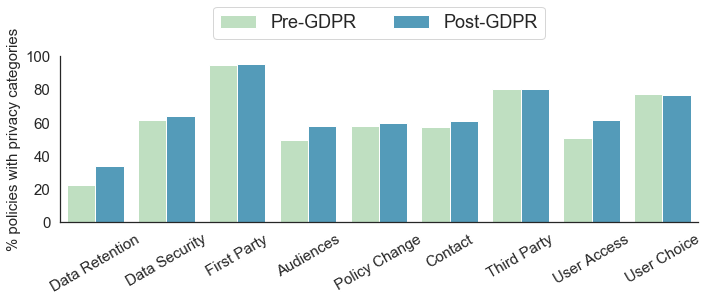

In [33]:
eu_coverage_df = pd.DataFrame.from_dict(eu_coverage_lod)
eu_coverage_df = eu_coverage_df.groupby(['category', 'source'], sort=False).sum().reset_index()
eu_coverage_df.sort_values(['category'], ascending=[True], inplace=True)
eu_coverage_df.sort_values(['source'], ascending=[True], inplace=True)
eu_coverage_df.sort_values(['category'], ascending=[True], inplace=True)
eu_coverage_plot = sns.catplot(x="category", y='num_covered_per', hue="source", data=eu_coverage_df, kind="bar", aspect=80 / 40, orient='v', ci=None, palette=two_palette, legend=False)
ax = eu_coverage_plot.ax
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
ax.set_ylabel('% policies with privacy categories', fontsize=15)
ax.set_xlabel('')
eu_coverage_plot.set_xticklabels(['Data Retention', 'Data Security', 'First Party', 'Audiences', 'Policy Change',
            'Contact', 'Third Party', 'User Access', 'User Choice'])
plt.xticks(rotation=30, fontsize=15)
plt.yticks(fontsize=15)

ax.legend(['Pre-GDPR', 'Post-GDPR'], loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=2, fontsize=18)
ax.set_ylim([0, 100])
plt.tight_layout()

**Global**

In [18]:
g_coverage_data = json.load(open('./polisis_queries/coverage/Global.json'))
g_coverage_by_category = {} # scoreboard
for pid in g_coverage_data:
    for src in ['archive', 'current']: # a.k.a pre/post
        for category in all_categories: 
            if g_coverage_by_category.get(category) is None: g_coverage_by_category[category] = {'archive': {'case':0, 'total':0}, 'current':{'case':0, 'total':0}}
            if category in g_coverage_data.get(pid).get(src): g_coverage_by_category[category][src]['case'] += 1
            g_coverage_by_category[category][src]['total'] += 1

            continue # categories
        continue # src    
    continue # pids 
    
g_coverage_lod = []
for cat in g_coverage_by_category:
    pre_case = g_coverage_by_category.get(cat).get('archive').get('case')
    pre_total = g_coverage_by_category.get(cat).get('archive').get('total')
    pre_pct = 100*pre_case/pre_total
    
    post_case = g_coverage_by_category.get(cat).get('current').get('case')
    post_total = g_coverage_by_category.get(cat).get('current').get('total')
    post_pct = 100*post_case/post_total
    
    g_coverage_lod.append({'category':cat, 'source':'archive', 'num_covered_per': pre_pct })
    g_coverage_lod.append({'category':cat, 'source':'current', 'num_covered_per': post_pct})
    continue 

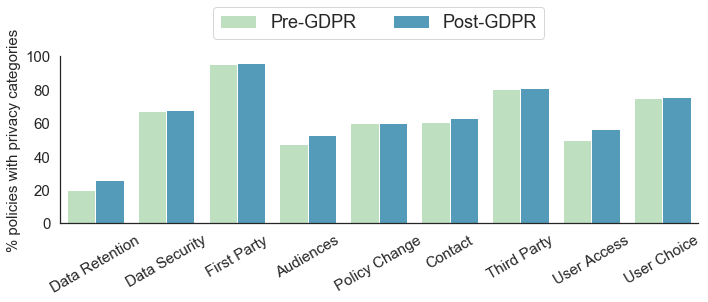

In [32]:
g_coverage_df = pd.DataFrame.from_dict(g_coverage_lod)
g_coverage_df = g_coverage_df.groupby(['category', 'source'], sort=False).sum().reset_index()
g_coverage_df.sort_values(['category'], ascending=[True], inplace=True)
g_coverage_df.sort_values(['source'], ascending=[True], inplace=True)
g_coverage_df.sort_values(['category'], ascending=[True], inplace=True)
g_coverage_plot = sns.catplot(x="category", y='num_covered_per', hue="source", data=g_coverage_df, kind="bar", aspect=80 / 40, orient='v', ci=None, palette=['#bae4bc', '#43a2ca'], legend=False)
ax = g_coverage_plot.ax
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
ax.set_ylabel('% policies with privacy categories', fontsize=15)
ax.set_xlabel('')
g_coverage_plot.set_xticklabels(['Data Retention', 'Data Security', 'First Party', 'Audiences', 'Policy Change',
            'Contact', 'Third Party', 'User Access', 'User Choice'])
plt.xticks(rotation=30, fontsize=15)
plt.yticks(fontsize=15)

ax.legend(['Pre-GDPR', 'Post-GDPR'], loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=2, fontsize=18)
ax.set_ylim([0, 100])
plt.tight_layout()

#### Understanding the results
It is evident from Figures above and that the GDPR has had a positive effect on the coverage of categories.
 Traditionally, privacy policies covered clauses mostly related to first party collection and third party sharing. With the introduction of the GDPR, it is clear that there is a trend of covering additional categories of particular importance to the GDPR requirements, including data retention periods (Article 13(2.a)), notices to special audiences, safeguarding the user data, and providing the users with the options to access and rectify their information.
Interestingly, the improvement in coverage of \textit{EU}  policies for these categories is higher than that of \textit{Global} policies. Finally, our manual analysis with subject matter experts shows that automatically extracting these results did not hinder their quality.

### Compliance Analysis (Section 8 from Paper)
Here we quantifu how the compliance requirements have changed by the introduction of the GDPR. We rely on the UK's Information Commissioner's officer's (ICO) guide to the GDPR , which contains a set of guidelines for organizations to meet the provisions set in the GDPR. For more details, please refer to section 8 of the [Paper](https://arxiv.org/pdf/1809.08396.pdf)

**EU**

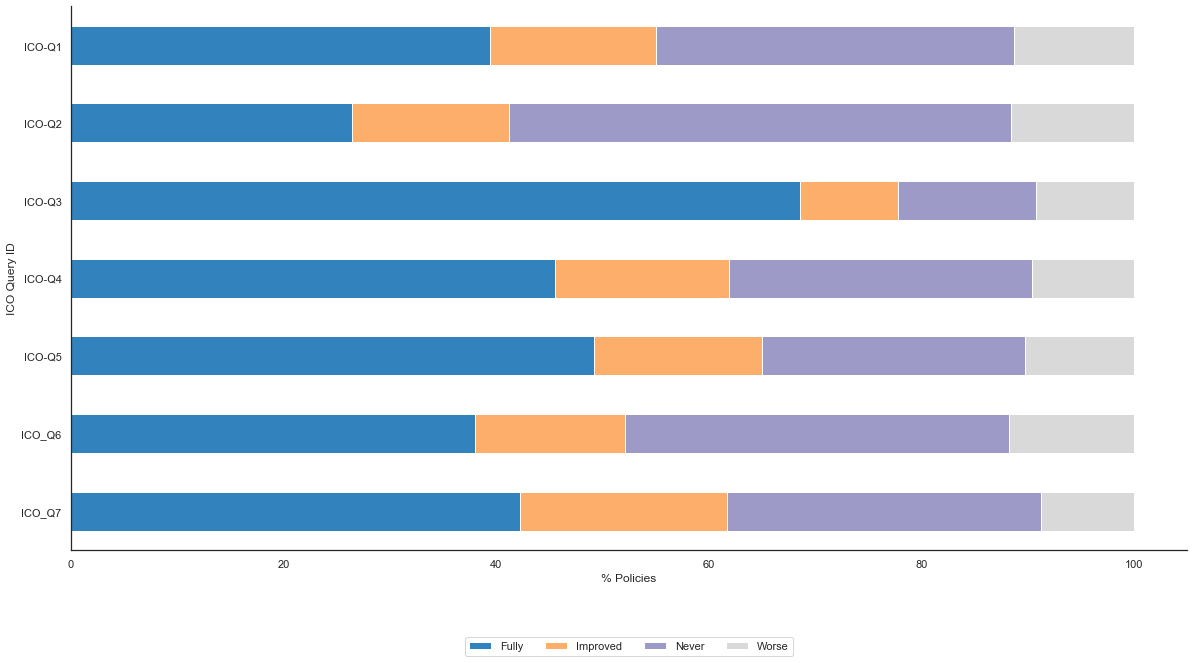

In [174]:
eu_compliance_data = json.load(open('./polisis_queries/compliance/EU.json'))

eu_compliance_by_query = {}
for pid in eu_compliance_data:
    queryset = eu_compliance_data.get(pid).get('queries').get('rights')
    for q in queryset:
        # Init if needed
        if eu_compliance_by_query.get(q) is None: eu_compliance_by_query[q] = {'fully':0, 'improved':0, 'never':0, 'worse':0}
        # Set flags for compliance
        is_pre_comp = queryset.get(q).get('archive').get('count') > 0
        is_post_comp = queryset.get(q).get('current').get('count') > 0 
        
        # Compare pre v. post
        result = (
            'fully' if is_pre_comp and is_post_comp else 
            'improved' if is_post_comp and not is_pre_comp else 
            'worse' if is_pre_comp and not is_post_comp else 
            'never'
        )
        
        # Update
        eu_compliance_by_query[q][result] += 1
        
        
        continue # queries
    continue # pids

eu_compliance_datarows = []
for query in eu_compliance_by_query:
    total = sum([eu_compliance_by_query.get(query).get(result) for result in ['fully', 'improved', 'worse', 'never']])
    eu_compliance_datarows.append({
        'query':query, 
        'fully':eu_compliance_by_query.get(query).get('fully')/total,
        'improved':eu_compliance_by_query.get(query).get('improved')/total,
        'worse':eu_compliance_by_query.get(query).get('worse')/total,
        'never':eu_compliance_by_query.get(query).get('never')/total,
    })
    

eu_compl_df = pd.DataFrame.from_dict(eu_compliance_datarows)
eu_compl_df = eu_compl_df.groupby('query', sort=False).agg(['sum'])
eu_plotter = eu_compl_df.div(eu_compl_df.sum(axis=1), axis=0).multiply(100)

eu_plotter.index = ['ICO-Q1','ICO-Q2','ICO-Q3','ICO-Q4','ICO-Q5','ICO_Q6','ICO_Q7']
eu_plotter = eu_plotter.reindex(index=eu_plotter.index[::-1])

ax = eu_plotter.plot(kind='barh', stacked=True, colormap='tab20c', sort_columns=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('ICO Query ID')
ax.set_xlabel('% Policies')
legend_list = ['Fully','Improved', 'Never', 'Worse']
plt.legend(legend_list, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)

**Global**

In [21]:
g_compliance_data = json.load(open('./polisis_queries/compliance/Global.json'))

g_compliance_by_query = {}
for pid in g_compliance_data:
    queryset = g_compliance_data.get(pid).get('queries').get('rights')
    for q in queryset:
        if q == 'retention_period_of_personal_data': continue
        # Init if needed
        if g_compliance_by_query.get(q) is None: g_compliance_by_query[q] = {'fully':0, 'improved':0, 'never':0, 'worse':0}
        # Set flags for compliance
        is_pre_comp = queryset.get(q).get('archive').get('count') > 0
        is_post_comp = queryset.get(q).get('current').get('count') > 0 
        
        # Compare pre v. post
        result = (
            'fully' if is_pre_comp and is_post_comp else 
            'improved' if is_post_comp and not is_pre_comp else 
            'worse' if is_pre_comp and not is_post_comp else 
            'never'
        )
        
        # Update
        g_compliance_by_query[q][result] += 1
        
        
        continue # queries
    continue # pids

g_compliance_datarows = []
for query in g_compliance_by_query:
    total = sum([g_compliance_by_query.get(query).get(result) for result in ['fully', 'improved', 'worse', 'never']])
    g_compliance_datarows.append({
        'query':query, 
        'fully':g_compliance_by_query.get(query).get('fully')/total,
        'improved':g_compliance_by_query.get(query).get('improved')/total,
        'worse':g_compliance_by_query.get(query).get('worse')/total,
        'never':g_compliance_by_query.get(query).get('never')/total,
    })
    

g_compl_df = pd.DataFrame.from_dict(g_compliance_datarows)
g_compl_df = g_compl_df.groupby('query', sort=False).agg(['sum'])
g_plotter = g_compl_df.div(g_compl_df.sum(axis=1), axis=0).multiply(100)

In [22]:
g_plotter.index = ['ICO-Q1','ICO-Q2','ICO-Q3','ICO-Q4','ICO-Q5','ICO_Q6','ICO_Q7']
g_plotter = g_plotter.reindex(index=g_plotter.index[::-1])

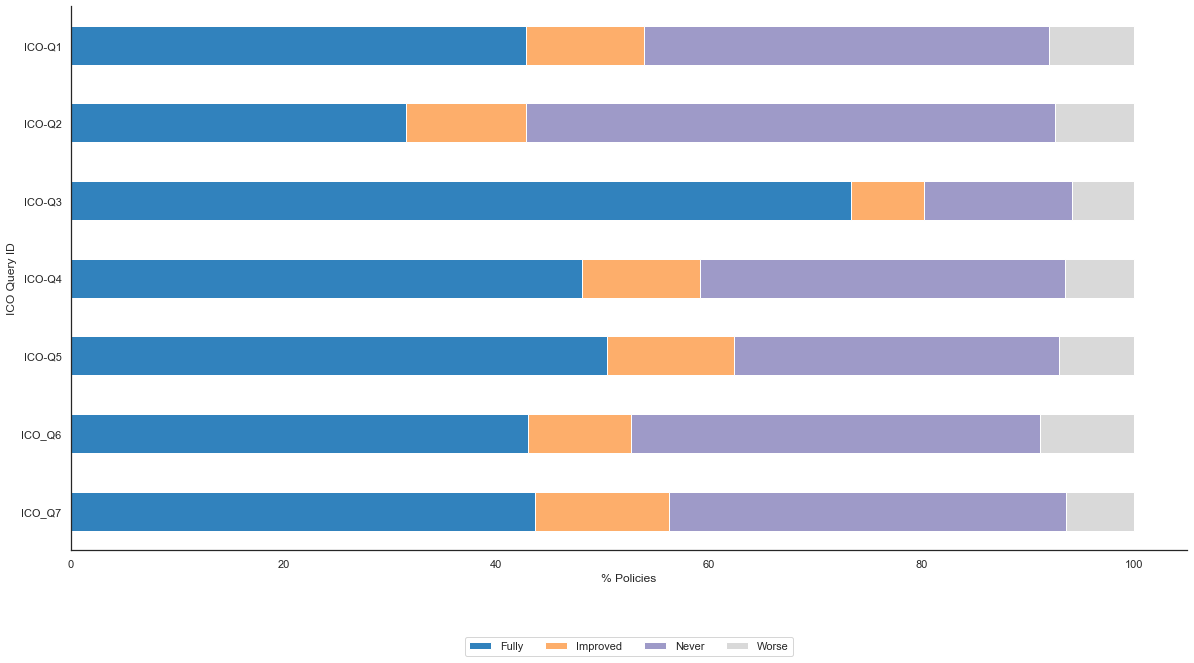

In [30]:
ax = g_plotter.plot(kind='barh', stacked=True, colormap='tab20c', sort_columns=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('ICO Query ID')
ax.set_xlabel('% Policies')
legend_list = ['Fully','Improved', 'Never', 'Worse']
plt.legend(legend_list, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)

#### Understanding the results
Similar to the coverage analysis, we find that the majority of the privacy policies, both inside and outside the EU, have incorporated the GDPR's privacy requirements we analyzed. On average, 59.3\% of the _EU_ post-GDPR policies and 58.2\% of the _Global_ post-GDPR policies meet our seven queries (combining Case 3 and Case 4). 
We also notice that policies state the recipients of user data (77.8\% _EU_, 80.3\% _Global_) and the collection sources of users' personal data (65\% _EU_, 62.4\% _Global_) fairly well across both sets of policies. 
On the other hand, both sets struggle in describing the categories of the collected data (41.3\% _EU_ and 42.8\% _Global_); for our compliance analysis, only this single query had less than 50\% of the post-GDPR policies comply. 

Comparing the two sets, we observe that the average score of compliance is higher for the \textit{EU} policies. Also, the average margin of improvement (from pre-GDPR to post-GDPR) across the chosen ICO requirements for the _EU_ set (4.8\%) is larger than that of the _Global_ set (3.5\%). 

### Specificity Analysis (Section 9 from paper)


**EU**

In [24]:
def get_query_scores(query):
    #print(query)
    S_curr = query['current']['S']
    S_a_curr = query['current']['S_a']
    S_arch = query['archive']['S']
    S_a_arch = query['archive']['S_a']
    arch_score = get_score(S_arch,S_a_arch)
    curr_score = get_score(S_curr, S_a_curr)
    return arch_score, curr_score

def get_score(S,S_a):
    if S_a == 0 and S == 0:
            #Our range is 0 to 1, returning 2 to help with the logic
            return 2
    elif S_a == 0:
        return 0
    else:
        return float(S_a*1.0/S)

Query Details : 
Q1 : Quantify how specifically the policy indicates how the first party is obtaining user data.

Q2 : Quantify how specifically the policy indicates how the third party is collecting user data

Q3 : Quantify how specifically the policy indicates the type of information accessed by the first party.

Q4 : Quantify how specifically the policy indicates the type of information shared with the third party.

Q5 : Quantify how specifically the policy indicates how the third party is receiving user information

Q6 : Quantify how specifically the policy covers first party collection purposes relative to all possible purposes in our taxonomy.

Q7 : Quantify how specifically the policy covers third party sharing purposes relative to all possible purposes in our taxonomy

Q8 : Quantify how specifically the policy indicates the purpose for data retention.

In [25]:
eu_specificity_data = json.load(open('./polisis_queries/specificity/EU.json'))

query_list = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

cols = ['no_ambiguity','still_same','worsened','improved','not_covered']
specificity_df = pd.DataFrame(0,columns=cols, index=sorted(query_list))
improved = {}
worsened = {}

for pid in eu_specificity_data:
    query_list = eu_specificity_data.get(pid)
    for query in query_list:
        query_name = query.split('-')[0]
        #print(query_name)
        #print(query_list[query])
        arch_score,curr_score = get_query_scores(query_list[query])
        if arch_score == 2 and curr_score == 2:
            col_id = "not_covered"
        elif arch_score == curr_score == 0:
            col_id = "no_ambiguity"
        elif arch_score == curr_score:
            col_id = "still_same"
        elif arch_score > curr_score:
            col_id = "improved"
            improved[(query, pid)] = (arch_score, curr_score)
        elif arch_score < curr_score:
            col_id = "worsened"
            worsened[(pid, query)] = (arch_score, curr_score)
        else:
            print("Did not go into any condition")
            print(arch_score, curr_score)
            col_id = "not_covered"
        if query_name not in specificity_df.index:
            print("Query not in index")
        specificity_df.at[query_name, col_id] = specificity_df.at[query_name, col_id] + 1


sum_df = specificity_df.sum(axis=1)

my_res = specificity_df.div(sum_df,axis=0)*100

my_res_2 = my_res.reindex(index=my_res.index[::-1])


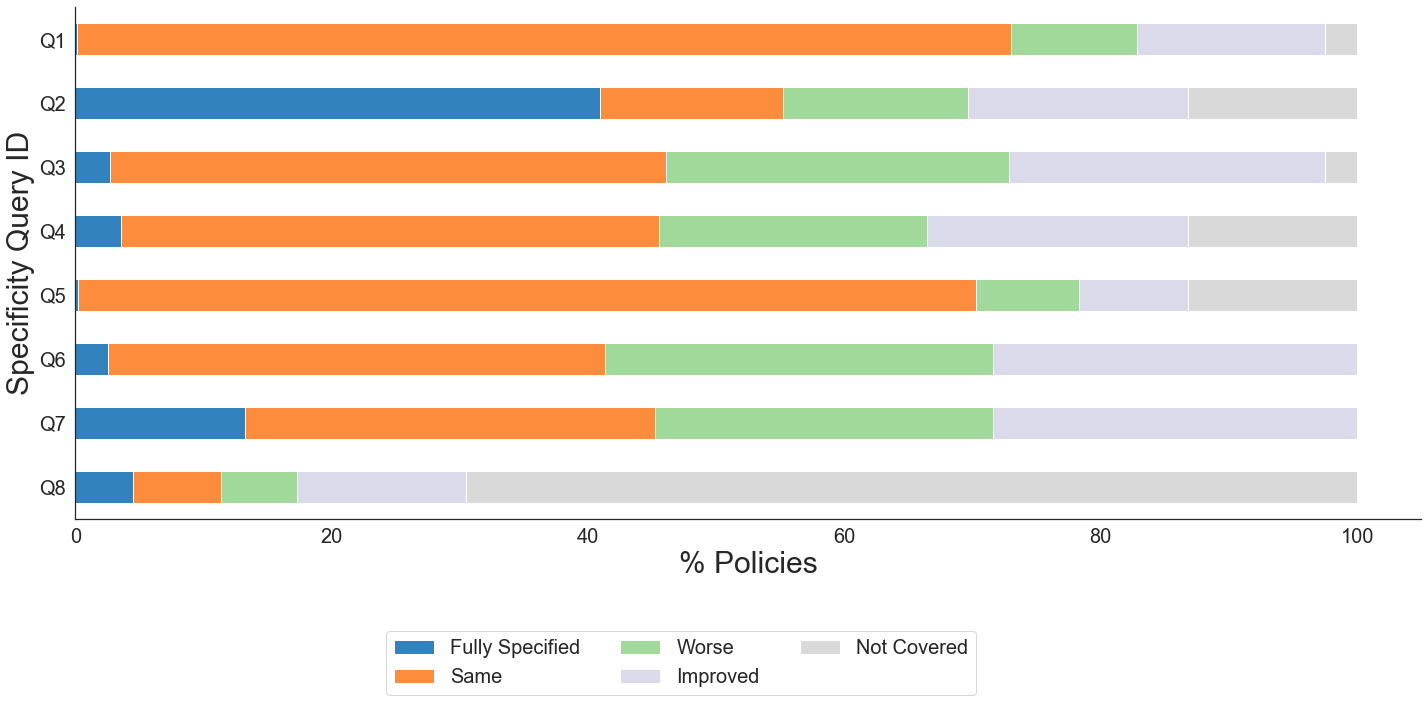

In [29]:
sns.set()
sns.set_style("white")
ax = my_res_2.plot(kind='barh', stacked=True, colormap='tab20c', sort_columns=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Specificity Query ID',fontsize=30)
ax.set_xlabel('% Policies',fontsize=30)
legend_list = ['Fully Specified', 'Same', 'Worse', 'Improved', "Not Covered"]
#filename = 'amb-queries_raw_Global.pdf'
plt.rcParams["figure.figsize"] = [20,10]
plt.legend(legend_list, loc='upper center', bbox_to_anchor=(0.45, -0.20), ncol=3,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.savefig(filename, dpi=400)

**Global**

In [27]:
global_specificity_data = json.load(open('./polisis_queries/specificity/Global.json'))

query_list = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

cols = ['no_ambiguity','still_same','worsened','improved','not_covered']
specificity_df = pd.DataFrame(0,columns=cols, index=sorted(query_list))
improved = {}
worsened = {}

for pid in global_specificity_data:
    query_list = global_specificity_data.get(pid)
    for query in query_list:
        query_name = query.split('-')[0]
        #print(query_name)
        #print(query_list[query])
        arch_score,curr_score = get_query_scores(query_list[query])
        if arch_score == 2 and curr_score == 2:
            col_id = "not_covered"
        elif arch_score == curr_score == 0:
            col_id = "no_ambiguity"
        elif arch_score == curr_score:
            col_id = "still_same"
        elif arch_score > curr_score:
            col_id = "improved"
            improved[(query, pid)] = (arch_score, curr_score)
        elif arch_score < curr_score:
            col_id = "worsened"
            worsened[(pid, query)] = (arch_score, curr_score)
        else:
            print("Did not go into any condition")
            print(arch_score, curr_score)
            col_id = "not_covered"
        if query_name not in specificity_df.index:
            print("Query not in index")
        specificity_df.at[query_name, col_id] = specificity_df.at[query_name, col_id] + 1


sum_df = specificity_df.sum(axis=1)

my_res = specificity_df.div(sum_df,axis=0)*100

my_res_2 = my_res.reindex(index=my_res.index[::-1])


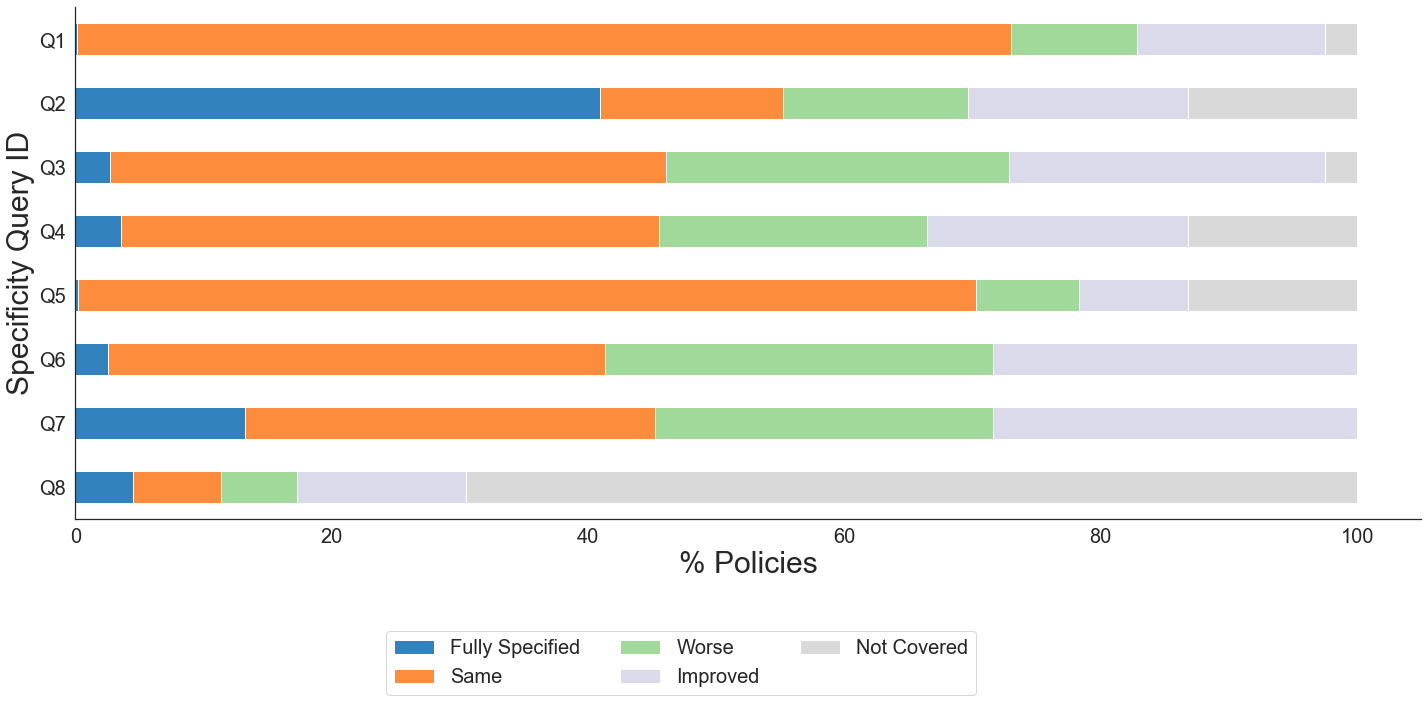

In [28]:
sns.set()
sns.set_style("white")
ax = my_res_2.plot(kind='barh', stacked=True, colormap='tab20c', sort_columns=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Specificity Query ID',fontsize=30)
ax.set_xlabel('% Policies',fontsize=30)
legend_list = ['Fully Specified', 'Same', 'Worse', 'Improved', "Not Covered"]
#filename = 'amb-queries_raw_Global.pdf'
plt.rcParams["figure.figsize"] = [20,10]
plt.legend(legend_list, loc='upper center', bbox_to_anchor=(0.45, -0.20), ncol=3,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.savefig(filename, dpi=400)

#### Understanding the Result
In conclusion, privacy policies appear to be more specific post the GDPR. While many of them have maintained the same specificity levels (due to unchanged policies or low coverage of data practices), a considerable number of policies has been changed. Of those policies, for both sets, a minority encountered reduced specificity according to our metrics; to comply with the GDPR, they have tried to be more comprehensive in describing their practices at the expense of being less specific. The majority of the policies that changed, however, have been more specific in informing the users about their privacy practices. 

When comparing the two sets, the _EU_ set exhibits a higher portion of improving policies than the _Global_ set for all the specificity queries. The _EU_ set also had a higher portion of policies with lower scores for each of the eight specificity queries. Recall that the _EU_ dataset has higher coverage of the related privacy practices. This result suggests that simply modifying a policy to increase coverage does not guarantee transparency to the data subjects. This can also be seen by analyzing policies whose coverage improved for a particular category, _e.g._ data retention. We find that more than 58\% of policies with improved data retention coverage are not fully specific (_i.e._ they have a specificity score of less than 1) suggesting that, despite better coverage, the transparent disclosure of the privacy information  is yet to be fully achieved. 